# Boundary conditions tutorial 
## (With QC Modifications for Devito Workshop at the 2026 Rice HPC/AI Energy Conference)

<details>
  <summary>Click to expand for more info</summary>

  * This notebook was modified to include QC Tasks and Curiosities by Thomas Cullison at Stanford University

  * The Original Devito notebook can be found on [GitHub](https://github.com/devitocodes/devito/blob/main/examples/userapi/04_boundary_conditions.ipynb)
</details>

This tutorial aims to demonstrate how users can implement various boundary conditions in Devito, building on concepts introduced in previous tutorials. More specifically, this tutorial will use `SubDomain`s to model boundary conditions. `SubDomain`s are the recommended way to model BCs in order to run with MPI and distributed memory parallelism, as they align with Devito's support for distributed NumPy arrays with zero changes needed to the user code.

Over the course of this notebook we will go over the implementation of both free surface boundary conditions and perfectly-matched layers (PMLs) in the context of the first-order acoustic wave equation. This tutorial is based on a simplified version of the method outlined in Liu and Tao's 1997 paper (https://doi.org/10.1121/1.419657).

We will set up our domain with PMLs along the left, right, and bottom edges, and free surface boundaries at the top as shown below.

<img src="https://raw.githubusercontent.com/devitocodes/devito/main/examples/userapi/figures/boundary_conditions.png" style="width: 220px;"/>

Note that whilst in practice we would want the PML tapers to overlap in the corners, this requires additional subdomains. As such, they are omitted for simplicity.

As always, we will begin by specifying some parameters for our `Grid`:

#### **QC Tip:** Enable autoreload for development testing in notebooks

In [1]:
%load_ext autoreload
%autoreload 2

#### **QC Tip:** It's good to make sure the notebook is using the version of Python expected

In [2]:
from sys import executable as mypythonexe
mypythonversion = !{mypythonexe} --version
print(f'Python EXE Path: {mypythonexe}')
print(f'Python Version:  {mypythonversion[0]}')

Python EXE Path: /Users/seismac/Documents/Python/mypy310/bin/python
Python Version:  Python 3.10.16


In [3]:
import matplotlib.pyplot as plt

In [4]:
# If able to use widgets, then you can easily zoom in/out of SubDomain boundaries
%matplotlib widget    
# %matplotlib inline

shape = (101, 101)
extent = (2000., 2000.)
nbpml = 10  # Number of PMLs on each side

We will need to use subdomains to accommodate the modified equations in the PML regions.

In [5]:
from devito import SubDomain

so = 6  # Space order


class MainDomain(SubDomain):  # Main section with no damping
    name = 'main'

    def __init__(self, pmls, so, grid=None):
        # NOTE: These attributes are used in `define`, and thus must be
        # set up before `super().__init__` is called.
        self.pmls = pmls
        self.so = so
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.pmls, self.pmls),
                y: ('middle', self.so//2, self.pmls)}


class Left(SubDomain):  # Left PML region
    name = 'left'

    def __init__(self, pmls, grid=None):
        self.pmls = pmls
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', self.pmls), y: y}


class Right(SubDomain):  # Right PML region
    name = 'right'

    def __init__(self, pmls, grid=None):
        self.pmls = pmls
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('right', self.pmls), y: y}


class Base(SubDomain):  # Base PML region
    name = 'base'

    def __init__(self, pmls, grid=None):
        self.pmls = pmls
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.pmls, self.pmls), y: ('right', self.pmls)}


class FreeSurface(SubDomain):  # Free surface region
    name = 'freesurface'

    def __init__(self, pmls, so, grid=None):
        self.pmls = pmls
        self.so = so
        super().__init__(grid=grid)

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.pmls, self.pmls), y: ('left', self.so//2)}

We create the grid and set up our subdomains:

In [6]:
from devito import Grid

grid = Grid(shape=shape, extent=extent)

main = MainDomain(nbpml, so, grid=grid)
left = Left(nbpml, grid=grid)
right = Right(nbpml, grid=grid)
base = Base(nbpml, grid=grid)
freesurface = FreeSurface(nbpml, so, grid=grid)

x, y = grid.dimensions

## **QC Task:** Create List of SubDomains 

#### (do not include the default SubDomain of the Grid)

* Also, try using both the "right" and "wrong_right" `SubDomain`s and visually compare both the SubDomian regions and the final wavefield results

In [7]:
# Correct subdomains
mysubdomains = [main,left,right,base,freesurface]

# Incorrect "right" subdomain (note the +1)
wrong_right = Right(nbpml+1, grid=grid)  
# mysubdomains = [main,left,wrong_right,base,freesurface]

## **QC Curiosity:** SubDomain Inheritance Probing

In [8]:
# First, lets see the default SubDomains

print(grid.subdomains)

{'domain': Domain[domain(x, y)], 'interior': Interior[interior(ix, iy)]}


In [9]:
# Now, lets look at some Inheritance Hierarchies

print('Grid Inheritance Hierarchy')
display(grid.__class__.__mro__)    
print()
print("Grid.subdomains['domain'] Inheritance Hierarchy")
display(grid.subdomains['domain'].__class__.__mro__)    
print()
print("Grid.subdomains['interior'] Inheritance Hierarchy")
display(grid.subdomains['interior'].__class__.__mro__)    
print()
display(main.__class__.__mro__) #This is one of the "created" SubDomains

Grid Inheritance Hierarchy


(devito.types.grid.Grid,
 devito.types.grid.CartesianDiscretization,
 abc.ABC,
 devito.types.args.ArgProvider,
 object)


Grid.subdomains['domain'] Inheritance Hierarchy


(devito.types.grid.Domain,
 devito.types.grid.SubDomain,
 devito.types.grid.AbstractSubDomain,
 devito.types.grid.CartesianDiscretization,
 abc.ABC,
 object)


Grid.subdomains['interior'] Inheritance Hierarchy


(devito.types.grid.Interior,
 devito.types.grid.SubDomain,
 devito.types.grid.AbstractSubDomain,
 devito.types.grid.CartesianDiscretization,
 abc.ABC,
 object)

(__main__.MainDomain,
 devito.types.grid.SubDomain,
 devito.types.grid.AbstractSubDomain,
 devito.types.grid.CartesianDiscretization,
 abc.ABC,
 object)

## **QC Task:** Show Some Fields for **ALL** Subdomains

* Some mistakes can be caught early just by verifying the shapes of each `SubDomain` is what is expected. 
* A visual method for examining `SubDomain`s is shown further below.

In [10]:
#Including default Subdomains from Grid
all_subdomains = list(grid.subdomains.values()) + mysubdomains 

for sd in all_subdomains:
    print(f'SubDomain Name:  {sd.name}')
    print(f'          Shape: {sd.shape}\n')

SubDomain Name:  domain
          Shape: (101, 101)

SubDomain Name:  interior
          Shape: (99, 99)

SubDomain Name:  main
          Shape: (81, 88)

SubDomain Name:  left
          Shape: (10, 101)

SubDomain Name:  right
          Shape: (10, 101)

SubDomain Name:  base
          Shape: (81, 10)

SubDomain Name:  freesurface
          Shape: (81, 3)



## **QC Task:** Create a List of Equations to Accumulatively Add Indivitial Subdomains

* This is step is for setting up a visual inspection of the `SubDomains`

In [11]:
# First import QC utility function

from devito_qc_utils import create_domain_functions_and_equations

In [12]:
# Then, generate the list of Equations

combined_equations, full_f = create_domain_functions_and_equations(grid,mysubdomains)

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


In [13]:
# Show the list of equations just created

display(combined_equations)

[Eq(full_f(x, y), full_f(x, y) + main_f(x, y)),
 Eq(full_f(x, y), full_f(x, y) + left_f(x, y) + main_f(x, y)),
 Eq(full_f(x, y), full_f(x, y) + left_f(x, y) + main_f(x, y) + right_f(x, y)),
 Eq(full_f(x, y), base_f(x, y) + full_f(x, y) + left_f(x, y) + main_f(x, y) + right_f(x, y)),
 Eq(full_f(x, y), base_f(x, y) + freesurface_f(x, y) + full_f(x, y) + left_f(x, y) + main_f(x, y) + right_f(x, y))]

## **QC Task:** Visually Plot the Regions Affected by Indivitial Subdomains from the Accumulation of Equations

In [14]:
# First import QC utility plotting function

from devito_qc_utils import plot_equation_grid

In [15]:
len(combined_equations)

5

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


axes.shape B4: (2, 3)
axes.shape AF: (6,)
target_func.data min/max: 0.0/5
levels: [-0.5  0.5  1.5  2.5  3.5  4.5  5.5]
target_func.data min/max: 0.0/5
levels: [-0.5  0.5  1.5  2.5  3.5  4.5  5.5]
target_func.data min/max: 0.0/5
levels: [-0.5  0.5  1.5  2.5  3.5  4.5  5.5]
target_func.data min/max: 0.0/5
levels: [-0.5  0.5  1.5  2.5  3.5  4.5  5.5]
target_func.data min/max: 1.0/5.0
levels: [-0.5  0.5  1.5  2.5  3.5  4.5  5.5]


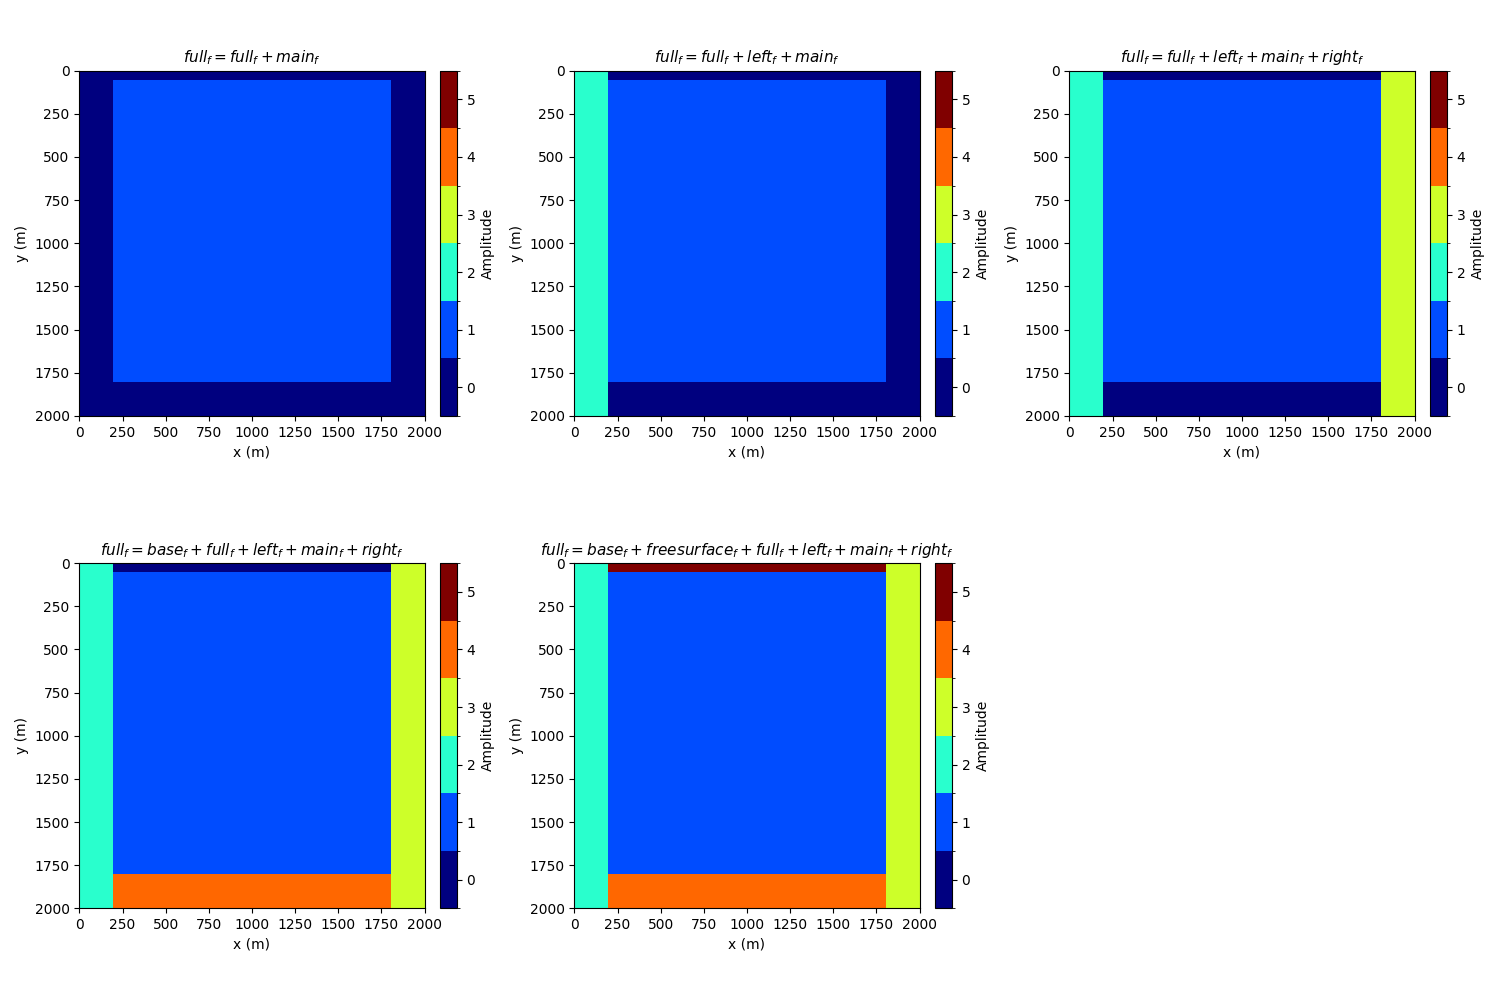

In [16]:
# Now, plot the combined equations as a grid of subplots (3 columns)

fig, axes = plot_equation_grid(combined_equations, full_f, grid, ncols=3)

fig.tight_layout()
plt.show()

# If you want to save the figure for slides or publications...
# fig.savefig("Figs/subdomain_regions.png", dpi=150, bbox_inches='tight')

We can then begin to specify our problem starting with some parameters.

In [17]:
density = 1.  # 1000kg/m^3
velocity = 4.  # km/s
gamma = 0.0002  # Absorption coefficient

We also need a `TimeFunction` object for each of our wavefields. As particle velocity is a vector, we will choose a `VectorTimeFunction` object to encapsulate it.

In [18]:
from devito import TimeFunction, VectorTimeFunction, NODE

p = TimeFunction(name='p', grid=grid, time_order=1,
                 space_order=so, staggered=NODE)
v = VectorTimeFunction(name='v', grid=grid, time_order=1,
                       space_order=so)

In [19]:
p.data.shape

(2, 101, 101)

A `VectorTimeFunction` is near identical in function to a standard `TimeFunction`, albeit with a field for each grid dimension. The fields associated with each component can be accessed as follows:

In [20]:
print(v[0].data)  # Print the data attribute associated with the x component of v

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


You may have also noticed the keyword `staggered` in the arguments when we created these functions. As one might expect, these are used for specifying where derivatives should be evaluated relative to the grid, as required for implementing formulations such as the first-order acoustic wave equation or P-SV elastic. Passing a function `staggered=NODE` specifies that its derivatives should be evaluated at the node. One can also pass `staggered=x` or `staggered=y` to stagger the grid by half a spacing in those respective directions. Additionally, a tuple of dimensions can be passed to stagger in multiple directions (e.g. `staggered=(x, y)`). `VectorTimeFunction` objects have their associated grids staggered by default.

We will also need to define a field for integrating pressure over time:

In [21]:
p_i = TimeFunction(name='p_i', grid=grid, time_order=1,
                   space_order=1, staggered=NODE)

Next we prepare the source term:

In [22]:
import numpy as np
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts at t=0
tn = 400.  # Simulation length in ms
dt = 1e2*(1. / np.sqrt(2.)) / 60.  # Time step

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.02
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# Position source centrally in all dimensions
src.coordinates.data[0, :] = 1000.

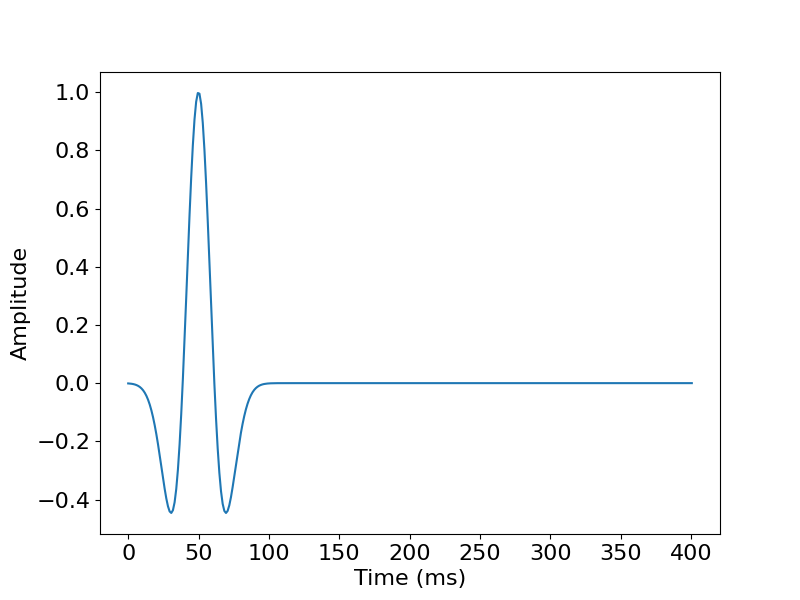

In [23]:
src.show()

For our PMLs, we will need some damping parameter. In this case, we will use a quadratic taper over the absorbing regions on the left and right sides of the domain.

In [24]:
# Damping parameterisation
d_l = (1-0.1*x)**2  # Left side
d_r = (1-0.1*(grid.shape[0]-1-x))**2  # Right side
d_b = (1-0.1*(grid.shape[1]-1-y))**2  # Base edge

Now for our main domain equations:

In [25]:
from devito import Eq, grad, div

eq_v = Eq(v.forward, v - dt*grad(p)/density,
          subdomain=main)

eq_p = Eq(p.forward, p - dt*velocity**2*density*div(v.forward),
           subdomain=main)

We will also need to set up `p_i` to calculate the integral of `p` over time for out PMLs:

In [26]:
eq_p_i = Eq(p_i.forward, p_i + dt*(p.forward+p)/2)

And add the equations for our damped region:

In [27]:
# Left side
eq_v_damp_left = Eq(v.forward,
                    (1-d_l)*v - dt*grad(p)/density,
                    subdomain=left)

eq_p_damp_left = Eq(p.forward,
                    (1-gamma*velocity**2*dt-d_l*dt)*p
                    - d_l*gamma*velocity**2*p_i
                    - dt*velocity**2*density*div(v.forward),
                    subdomain=left)

# Right side
eq_v_damp_right = Eq(v.forward,
                     (1-d_r)*v - dt*grad(p)/density,
                     subdomain=right)

eq_p_damp_right = Eq(p.forward,
                     (1-gamma*velocity**2*dt-d_r*dt)*p
                     - d_r*gamma*velocity**2*p_i
                     - dt*velocity**2*density*div(v.forward),
                     subdomain=right)

# Base edge
eq_v_damp_base = Eq(v.forward,
                    (1-d_b)*v - dt*grad(p)/density,
                    subdomain=base)

eq_p_damp_base = Eq(p.forward,
                    (1-gamma*velocity**2*dt-d_b*dt)*p
                    - d_b*gamma*velocity**2*p_i
                    - dt*velocity**2*density*div(v.forward),
                    subdomain=base)

Next, we will add our free surface boundary conditions. Note that this implementation is based on that found in `examples/seismic/acoustic/operators.py`.

In [28]:
from devito import sign, norm
from devito.symbolics import retrieve_functions, INT


def free_surface_top(eq, subdomain, update):
    """
    Modify a stencil such that it is folded back on
    itself rather than leaving the model domain. This is
    achieved by replacing the symbolic indices for some
    function of those indices. Depending on how this is
    done, this can be used to implement a pressure or
    velocity free-surface. This is the MPI-safe method
    of implementing a free-surface boundary condition
    in Devito.

    Parameters
    ----------
    eq : Eq
        The update stencil to modify
    subdomain : FreeSurface
        The subdomain in which the modification is
        applied
    update : str
        The field being updated: 'pressure' or 'velocity'
    """
    lhs, rhs = eq.evaluate.args

    # Get vertical subdimension and its parent
    yfs = subdomain.dimensions[-1]
    y = yfs.parent

    # Functions present in stencil
    funcs = retrieve_functions(rhs)
    mapper = {}
    for f in funcs:
        # Get the y index
        yind = f.indices[-1]
        if (yind - y).as_coeff_Mul()[0] < 0:
            # If point position in stencil is negative
            # Substitute the dimension for its subdomain companion
            # Get the symbolic sign of this
            s = sign(yind.subs({y: yfs, y.spacing: 1}))
            if update == 'velocity':
                # Antisymmetric mirror
                # Substitute where index is negative for -ve where index is positive
                mapper.update({f: s*f.subs({yind: INT(abs(yind))})})
            elif update == 'pressure':
                # Symmetric mirror
                # Substitute where index is negative for +ve where index is positive
                mapper.update({f: f.subs({yind: INT(abs(yind))})})
    return Eq(lhs, rhs.subs(mapper), subdomain=subdomain)


fs_p = free_surface_top(eq_p, freesurface, 'pressure')
fs_v = free_surface_top(eq_v, freesurface, 'velocity')

And our source terms:

In [29]:
src_term = src.inject(field=p.forward, expr=src)

Construct our operator and run:

In [30]:
from devito import Operator

op = Operator([eq_v, fs_v, eq_v_damp_left, eq_v_damp_base, eq_v_damp_right,
               eq_p, fs_p, eq_p_damp_left, eq_p_damp_base, eq_p_damp_right,
               eq_p_i]
               + src_term)

op(time=time_range.num-1)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0018100000000000037, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.001873000000000003, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.00048000000000000186, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=1e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

It is important to remember that the ordering of equations when an `Operator` is created dictates the order of loops within the generated c code. As such, the `v` equations need to be placed before the `p` ones; otherwise, the operator will attempt to use the updated `v` fields before they have been updated.

Now, let's plot the wavefield.

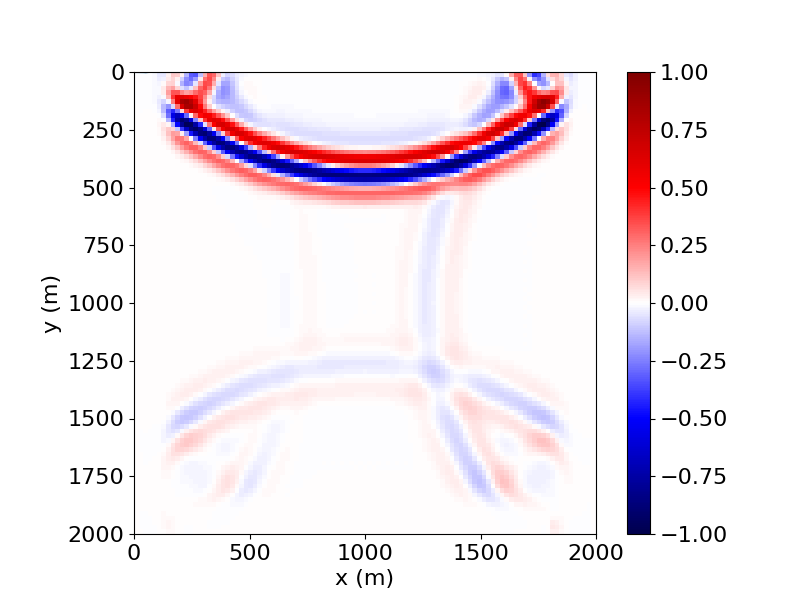

In [31]:
import matplotlib.pyplot as plt

scale = np.max(np.abs(p.data[1]))
plt.imshow(p.data[1].T/scale,
           origin="upper",
           vmin=-1, vmax=1,
           extent=[0, grid.extent[0], grid.extent[1], 0],
           cmap='seismic')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

As we can see, the wave is effectively damped at the edge of the domain by the 10 layers of PMLs, with diminished reflections back into the domain.

In [32]:
assert(np.isclose(norm(v[0]), 0.1955, atol=0, rtol=1e-4))
assert(np.isclose(norm(v[1]), 0.4596, atol=0, rtol=1e-4))
assert(np.isclose(norm(p), 2.0043, atol=0, rtol=1e-4))

## **QC Task:** Overlay the Final Plot of the SubDomains On Top of the Final Wavefield

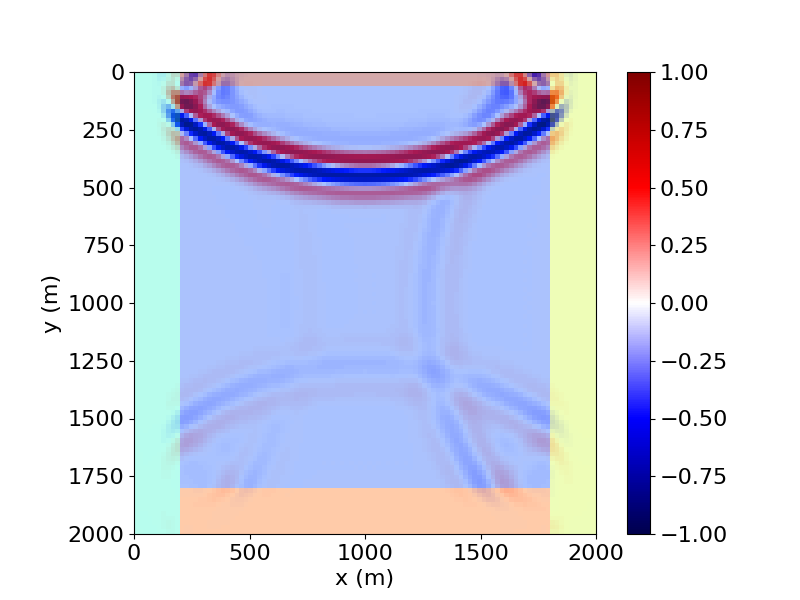

In [33]:
scale = np.max(np.abs(p.data[1]))
main_img = p.data[1].T / scale

# Get overlay image data from axes[-1]
overlay_img = axes[-2].images[0].get_array()
overlay_cmap = axes[-2].images[0].get_cmap()
overlay_vmin, overlay_vmax = axes[-2].images[0].get_clim()

fig, ax = plt.subplots()

# Plot main image
im1 = ax.imshow(main_img,
                origin="upper",
                vmin=-1, vmax=1,
                extent=[0, grid.extent[0], grid.extent[1], 0],
                cmap='seismic')

# Overlay with transparency
im2 = ax.imshow(overlay_img,
                origin="upper",
                vmin=overlay_vmin, vmax=overlay_vmax,
                extent=[0, grid.extent[0], grid.extent[1], 0],
                cmap=overlay_cmap,
                alpha=0.33)  # Adjust alpha as needed

plt.colorbar(im1, ax=ax)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()